In [840]:
import numpy as np
import matplotlib.pyplot as plt

values for prior obtained from published papers

In [841]:
#values are taken from DESI 2024 VI: Cosmological Constraints.. 
w0_mean = -0.827
w0_sigma = 0.0632
wa_mean =  0.75
wa_sigma = 0.272
#correlation value assumed from Planck 2018
p = -0.8

#variances on the diagonal of cov matrix 
cov_00 = w0_sigma**2 
cov_11 = wa_sigma**2  
#covariances on off-diagonal of cov matrix 
cov_01 = p * w0_sigma * wa_sigma 

#covariance matrix is symmetric
cov_10 = cov_01 
cov_matrix = np.array([
    [cov_00, cov_01], 
    [cov_10, cov_11]])

#mean vector
#the mean vector is the center of the 2D Gaussian distribution
mu = np.array([w0_mean, wa_mean])

generating a 2D gaussian grid and evaluating the PDF; constructing a grid of values centered around the mean, ensuring that most the probability is captured, finding the probability density of the 2D gaussian at each grid point, Z = PDF values needed for contour lines

In [842]:
#grid of points for the contour plot of 2D Gaussian distribution defined by the mean vector and covariance matrix
#grid covers a range around the mean, scaled by the standard deviations, set to cover 5 standard deviations in each direction
#500 values between muw0 +/- 5*sigmaw0 and muwa +/- 5*sigmawa
#99.99994% of the probability mass is within +/- 5σ
x = np.linspace(mu[0] - 5*w0_sigma, mu[0] + 5*w0_sigma, 500)
y = np.linspace(mu[1] - 5*wa_sigma, mu[1] + 5*wa_sigma, 500)
#create a meshgrid for the contour plot
#2D arrays X/Y = coordinates for the grid points (X = w0, Y = wa)
X, Y = np.meshgrid(x, y)

#calculate the 2D Gaussian distribution values for each point in the grid using the multivariate normal distribution formula
#the formula is: P(x) = (1 / (2 * pi * sqrt(det(cov)))) * exp(-0.5 * (x - mu).T @ inv(cov) @ (x - mu))
from scipy.stats import multivariate_normal
#np.dstack combines X and Y into a 2D array where each row is a point (w0, wa)
#so position[i, j] = [X[i,j], Y[i,j]]
#function from scipy.stats computes the value of the gaussian probability distribution function at each point in that array
Z = multivariate_normal.pdf(np.dstack((X, Y)), mean=mu, cov=cov_matrix) 


plotting filled and line contours for the 2D prior over w0 and wa

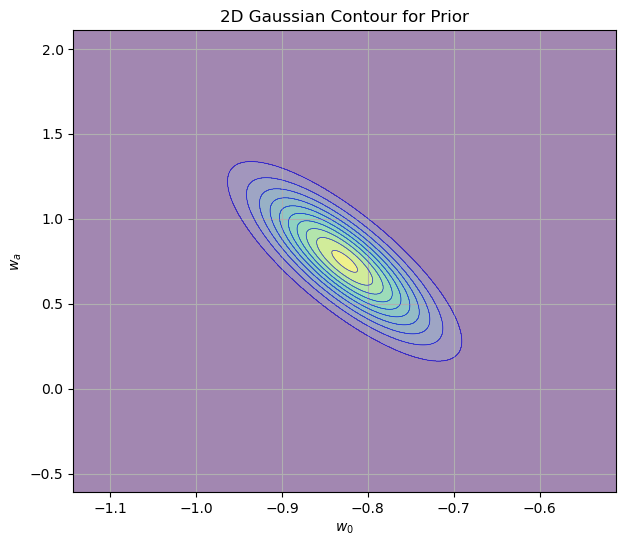

In [843]:
#plot the contour lines of the 2D Gaussian distribution
plt.figure(figsize=(7,6))
#each contour line encloses region of constant probability density
#uncertainty in each parameter = how wide the ellipse is 
#correlation between parameters = ellipse angle
#if negatively correlated = ellipses tilt downward
contour = plt.contourf(X, Y, Z, levels=10, alpha=0.5)
contourx = plt.contour(X, Y, Z, levels=10, colors='blue', linewidths=0.5, alpha=0.8)

#setting the labels and title for the plot
plt.xlabel('$w_0$')
plt.ylabel('$w_a$')
plt.title("2D Gaussian Contour for Prior")
plt.grid(True)
plt.show()

calculating 1-5 sigma contour levels using chi squared, used because the confidence region is defined by the mahalanobis distance (follows a chi-squared distribution with 2 degrees of freedom), finding the chi squared thresholds that enclose the probability mass, convert them to PDF heights using the exponential fall off formula

In [844]:
#importing chi2 from scipy.stats to calculate the levels for the contour plot
from scipy.stats import chi2

#ensuring that the 5*sigma ecllipse is captured in the plot by using a larger range
#the range is set to cover 8*sigma in each direction, which captures 99.9999994% of the probability mass 
x1 = np.linspace(w0_mean - 8*w0_sigma, w0_mean + 8*w0_sigma, 500)
y1 = np.linspace(wa_mean - 8*wa_sigma, wa_mean + 8*wa_sigma, 500)
#creating a new meshgrid for the larger range - defines the parameter space for plot 
X1, Y1 = np.meshgrid(x1, y1)
#2D gaussian distribution values for the new grid using the same mean vector and covariance matrix as before
Z1 = multivariate_normal.pdf(np.dstack((X1, Y1)), mean=mu, cov=cov_matrix) 

#finding the chi squared values for the confidence regions 
#converts confidence levels to chi-squared values for 2 degrees of freedom (2D = w0 and wa)
#ppf = inverse CDF (percent point function) for chi-squared distribution (what chi squared value gives x% confidence?)
#inputting confidence levels for 1σ, 2σ, 3σ, 4σ, and 5σ 
#converts to chi squared treshholds (|x-mu|^2 / sigma^2) < chi2_value = Mahalanobis Radius
chi2_values = chi2.ppf([0.683, 0.954, 0.997, 0.99994, 0.9999994], df=2) 

#convert chi sqaured region to PDF levels = height, using: level = peak * exp(-0.5 * chi2)
#works because multivariate Gaussian PDF falls off exponentially from the peak
#at distance sqrt(chi2) from the mean, the PDF value is reduced by a factor of exp(-0.5 * chi2) from peak value = f_peak 
f_peak = multivariate_normal(mean=mu, cov=cov_matrix).pdf(mu)
levels1 = f_peak * np.exp(-0.5 * chi2_values)
levels = sorted(levels1)

plotting 1-5 sigma confidence contours for prior

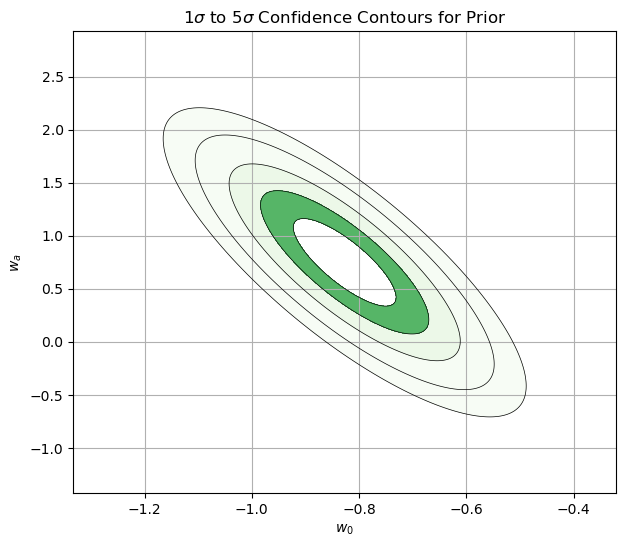

In [845]:
#plotting the contour again with the new levels - this time for 1σ to 5σ confidence contours 
plt.figure(figsize=(7,6))
contour1 = plt.contourf(X1, Y1, Z1, levels=levels, cmap='Greens')
contour2 = plt.contour(X1, Y1, Z1, levels=levels, colors='black', linewidths=0.5)

#setting the labels and title for the plot
plt.xlabel('$w_0$')
plt.ylabel('$w_a$')
plt.title('1$\sigma$ to 5$\sigma$ Confidence Contours for Prior')
plt.grid(True)

In 1D (w0 and wa separately):

computing required likelihood widths for target tension in the posterior mean for w0 first, seeing how the likelihood precision needs to be tuned for desired tension. new sig: finding the posterior std, new mean = finding the posterior mean, posterior tension: finding the tension between the posterior and the prior, find sigma for T: using numerical root finding to find a value for sigma 2. setting a target tension and looping over alpha 1-5 in order to find sigma 2 values for each.

In [846]:
from scipy.optimize import minimize_scalar

#same formulas from lab code 
#compute the posterior width from prior and likelihood widths using the Gaussian product formula
def new_sig(sig1, sig2):
    return 1 / np.sqrt(1/sig1**2 + 1/sig2**2)

#finding the mean of the posterior 
def new_mean(sig1, sig2, alpha):
    return (alpha * sig1) / (1 + (sig2**2 / sig1**2))

#tension: how far the posterior mean is from the prior mean, measured in units of posterior std
#tension T = posterior mean / posterior std 
def posterior_tension(sig1, sig2, alpha):
    return new_mean(sig1, sig2, alpha) / new_sig(sig1, sig2)

#inverting the process: we want to find the value of sigma2 that gives us a posterior tension T close to target tension 
#cant solve algebraically, so we use numerical optimization to find the value of sigma2 that minimizes the difference
#between the posterior tension and the target tension - using scipy's minimize_scalar function
#function tries many values and finds the value of sigma2 that gives us a posterior tension close to target_t 
def find_sigma2_for_T(sig1, alpha, target_t):
    def objective(sig2):
        T = posterior_tension(sig1, sig2, alpha)
        #minimising the absolute difference between posterior tension and target tension
        return abs(T - target_t)
    #guess for sigma2 in bounds to start, adjusts until the difference is small enough (1e-5) = numerical root finding
    result = minimize_scalar(objective, bounds=(1e-5, 1.0), method='bounded')
    return result.x if result.success else None

#using the w0 prior standard deviation as sig1 
sig1 = 0.0632
#want posterior mean to be 5 sigmas from 0
target_t = 5 

sig2_w0 = []

for alpha in [1, 2, 3, 4, 5]:
    required_sig2 = find_sigma2_for_T(sig1, alpha, target_t)
    print(f"For alpha = {alpha}, required sigma2 = {required_sig2:.5f}")
    sig2_w0.append(required_sig2) 



For alpha = 1, required sigma2 = 0.01240
For alpha = 2, required sigma2 = 0.02367
For alpha = 3, required sigma2 = 0.03350
For alpha = 4, required sigma2 = 0.04208
For alpha = 5, required sigma2 = 0.04968


plotting how the required sigmas vary with alpha for w0

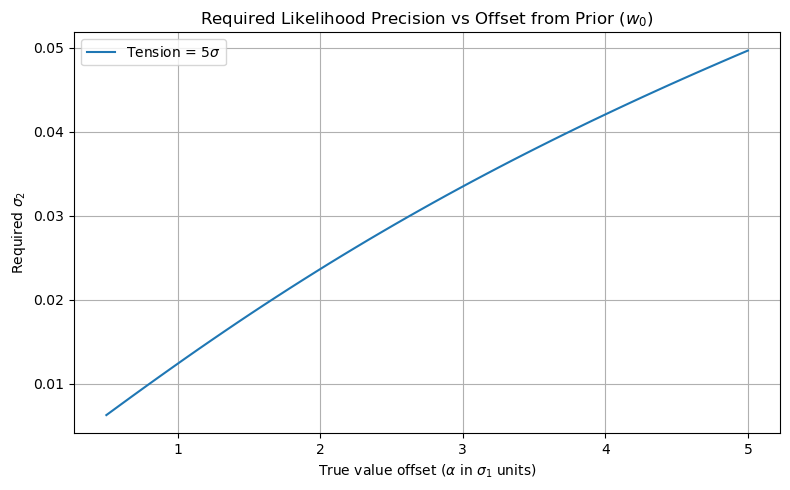

In [847]:
#using a finer range of alpha values
alphas = np.linspace(0.5, 5, 50)
#calculating the required sigma2 for each alpha value using a loop 
sigma2s = [find_sigma2_for_T(sig1, alpha, target_t) for alpha in alphas]

#plotting the required likelihood precision vs offset from prior
plt.figure(figsize=(8,5))
plt.plot(alphas, sigma2s, label=f'Tension = {target_t}$\sigma$')
plt.xlabel(r'True value offset ($\alpha$ in $\sigma_1$ units)')
plt.ylabel(r'Required $\sigma_2$')
plt.title('Required Likelihood Precision vs Offset from Prior ($w_0$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


same thing for wa - just changing the prior std 

In [848]:
#using the wa prior standard deviation as sig1 
sig1_2 = 0.272
#want posterior mean to be 5 sigmas from 0
target_t = 5 

sig2_wa = []

for alpha in [1, 2, 3, 4, 5]:
    required_sig2_2 = find_sigma2_for_T(sig1_2, alpha, target_t)
    print(f"For alpha = {alpha}, required sigma2 = {required_sig2_2:.5f}")
    sig2_wa.append(required_sig2_2)


For alpha = 1, required sigma2 = 0.05338
For alpha = 2, required sigma2 = 0.10189
For alpha = 3, required sigma2 = 0.14419
For alpha = 4, required sigma2 = 0.18112
For alpha = 5, required sigma2 = 0.21383


plotting wa in the same way

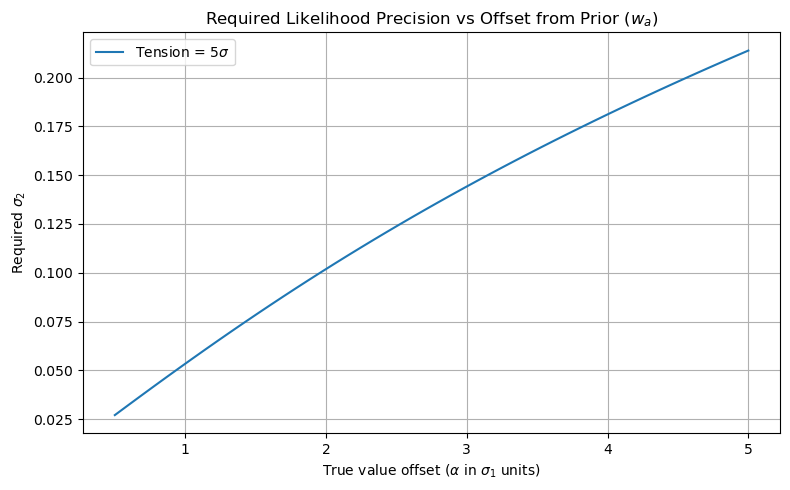

In [849]:
#calculating the required sigma2 for each alpha value using a loop 
sigma2s_2 = [find_sigma2_for_T(sig1_2, alpha, target_t) for alpha in alphas]

#plotting the required likelihood precision vs offset from prior
plt.figure(figsize=(8,5))
plt.plot(alphas, sigma2s_2, label=f'Tension = {target_t}$\sigma$')
plt.xlabel(fr'True value offset ($\alpha$ in $\sigma_1$ units)')
plt.ylabel(fr'Required $\sigma_2$')
plt.title('Required Likelihood Precision vs Offset from Prior ($w_a$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Can see that towards left of curve, need very precise experiments (small sigma) if the true value is close to the prior. As the true value deviates more from the prior, the std (sigma2) can be larger to produce the same tension value (T). 

visiualising the prior, likelihood and posterior curves of the 1D gaussians for w0, for a given alpha value - how many prior std units the likelihood is shifted from the prior mean. posterior computed from the product of gaussians, results in a smaller std since there is combined data. 

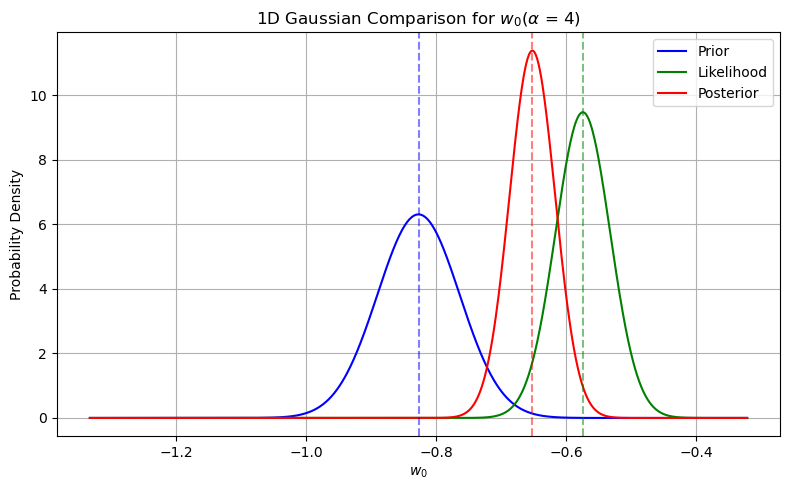

In [850]:
from scipy.stats import norm

#choosing an alpha value for the 1D gaussian comparison 
alpha = 4
#extracting the required sigma2 for the chosen alpha
sigma2_w0 = sig2_w0[alpha - 1]

#extracting the prior value for w0 and its standard deviation 
mu_prior = mu[0] 
sigma1 = np.sqrt(cov_matrix[0, 0])

#finding the mean of the likelihood (alpha std away)
mu_like = mu_prior + alpha * sigma1

#finding the posterior mean and std for w0 (1D) - using the gaussian product formula 
var_post = 1 / (1/sigma1**2 + 1/sigma2_w0**2)
mu_post = var_post * (mu_prior/sigma1**2 + mu_like/sigma2_w0**2)
sigma_post = np.sqrt(var_post)

#plotting the range for comparison 
x = np.linspace(mu_prior - 8*sigma1, mu_prior + 8*sigma1, 1000)

#plotting 1D gaussians using scipy's norm.pdf for prior, likelihood, and posterior 
plt.figure(figsize=(8, 5))
plt.plot(x, norm.pdf(x, mu_prior, sigma1), 'b-', label='Prior')
plt.plot(x, norm.pdf(x, mu_like, sigma2_w0), 'g-', label='Likelihood')
plt.plot(x, norm.pdf(x, mu_post, sigma_post), 'r-', label='Posterior')

#indicating the means of the prior, likelihood, and posterior with dashed lines
plt.axvline(mu_prior, color='blue', linestyle='--', alpha=0.5)
plt.axvline(mu_like, color='green', linestyle='--', alpha=0.5)
plt.axvline(mu_post, color='red', linestyle='--', alpha=0.5)

plt.title(fr'1D Gaussian Comparison for $w_0 (\alpha$ = {alpha})')
plt.xlabel(fr'$w_0$')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


doing the same for wa

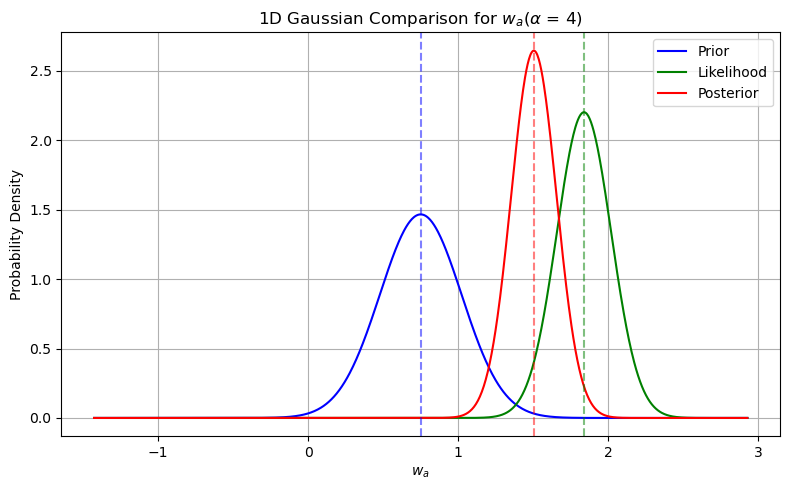

In [851]:
#extracting the required sigma2 for the chosen alpha
sigma2_wa = sig2_wa[alpha - 1]

#extracting the prior value for w0 and its standard deviation 
mu_prior = mu[1] 
sigma1 = np.sqrt(cov_matrix[1, 1])

#finding the mean of the likelihood (alpha std away)
mu_like = mu_prior + alpha * sigma1

#finding the posterior mean and std for wa (1D) - using the gaussian product formula 
var_post = 1 / (1/sigma1**2 + 1/sigma2_wa**2)
mu_post = var_post * (mu_prior/sigma1**2 + mu_like/sigma2_wa**2)
sigma_post = np.sqrt(var_post)

#plotting the range for comparison 
x = np.linspace(mu_prior - 8*sigma1, mu_prior + 8*sigma1, 1000)

#plotting 1D gaussians using scipy's norm.pdf for prior, likelihood, and posterior 
plt.figure(figsize=(8, 5))
plt.plot(x, norm.pdf(x, mu_prior, sigma1), 'b-', label='Prior')
plt.plot(x, norm.pdf(x, mu_like, sigma2_wa), 'g-', label='Likelihood')
plt.plot(x, norm.pdf(x, mu_post, sigma_post), 'r-', label='Posterior')

#indicating the means of the prior, likelihood, and posterior with dashed lines
plt.axvline(mu_prior, color='blue', linestyle='--', alpha=0.5)
plt.axvline(mu_like, color='green', linestyle='--', alpha=0.5)
plt.axvline(mu_post, color='red', linestyle='--', alpha=0.5)

plt.title(fr'1D Gaussian Comparison for $w_a (\alpha$ = {alpha})')
plt.xlabel(r'$w_a$')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

the curves look very similar but are distanced different amounts apart - based on whether looking at w0 or wa. probability density for w0 is much higher than wa. height of 1D gaussian PDF is inversely proportional to std = narrower distribution = smaller std = higher peak since concentrates more prob density near the mean. w0 has much smaller std than wa

same thing - looped over all alphas in order to visualise the change of posterior gaussian distribution with change in alpha (for w0)

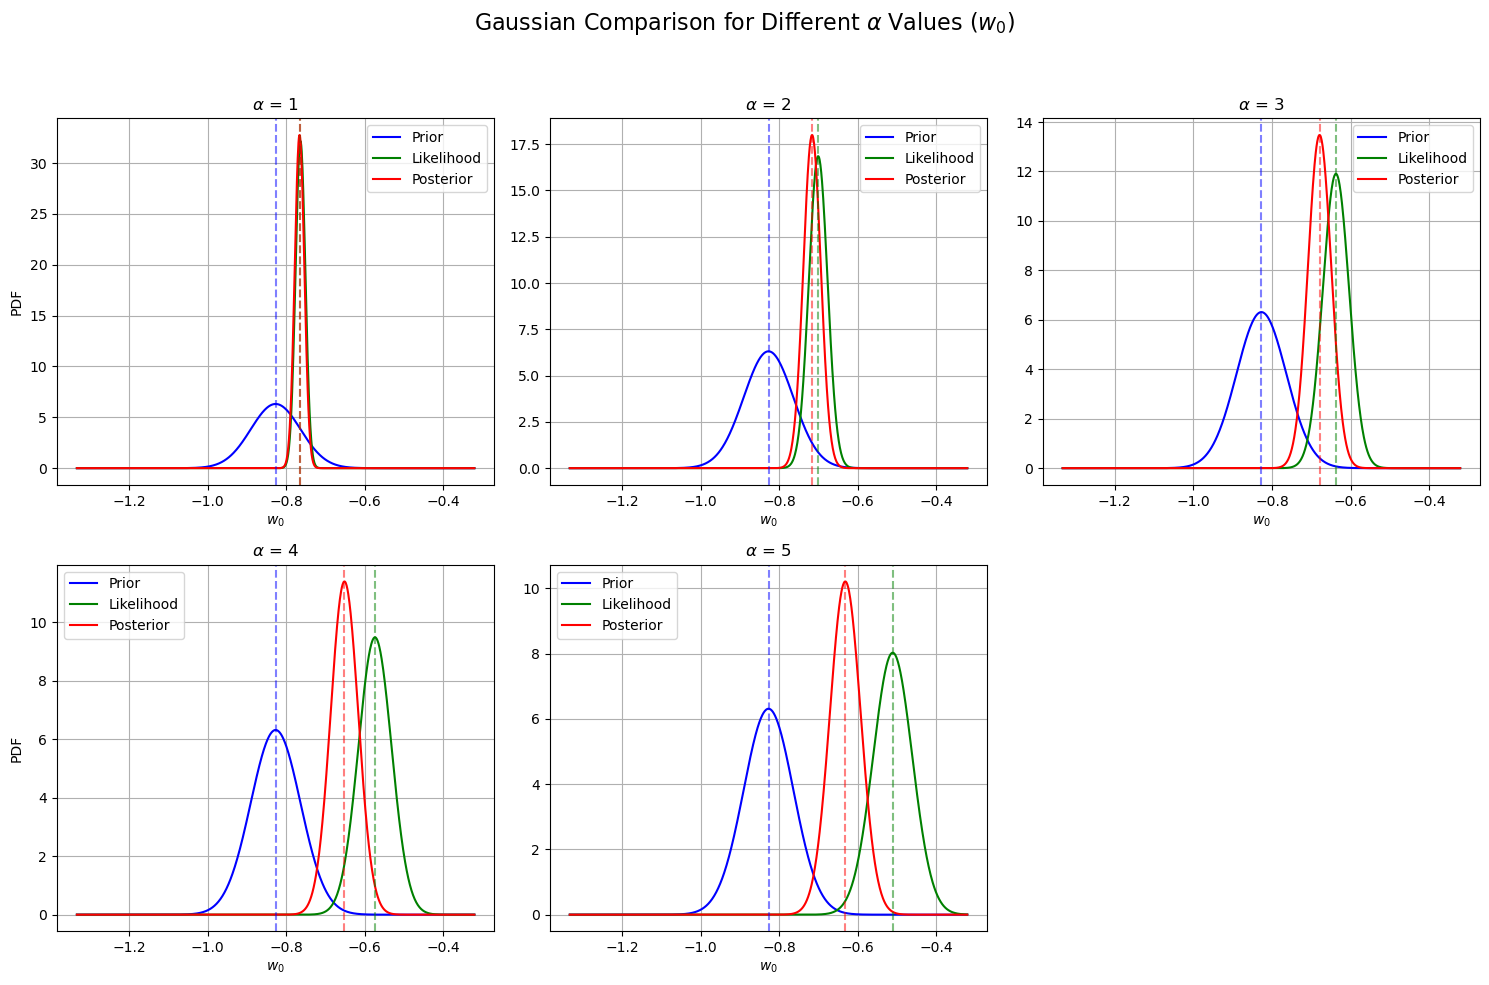

In [852]:
alphas = [1, 2, 3, 4, 5]
sigma1 = np.sqrt(cov_matrix[0, 0])
mu_prior = mu[0]
x = np.linspace(mu_prior - 8*sigma1, mu_prior + 8*sigma1, 1000)

plt.figure(figsize=(15, 10))
for i, alpha in enumerate(alphas, 1):
    #extracting corresponding sigma2 for the given alpha
    sigma2 = sig2_w0[alpha - 1]
    
    #computing the likelihood mean
    mu_like = mu_prior + alpha * sigma1
    
    #compute posterior variance and mean
    var_post = 1 / (1/sigma1**2 + 1/sigma2**2)
    mu_post = var_post * (mu_prior/sigma1**2 + mu_like/sigma2**2)
    sigma_post = np.sqrt(var_post)
    
    #plot subplot
    plt.subplot(2, 3, i)
    plt.plot(x, norm.pdf(x, mu_prior, sigma1), 'b-', label='Prior')
    plt.plot(x, norm.pdf(x, mu_like, sigma2), 'g-', label='Likelihood')
    plt.plot(x, norm.pdf(x, mu_post, sigma_post), 'r-', label='Posterior')
    
    plt.axvline(mu_prior, color='blue', linestyle='--', alpha=0.5)
    plt.axvline(mu_like, color='green', linestyle='--', alpha=0.5)
    plt.axvline(mu_post, color='red', linestyle='--', alpha=0.5)
    
    plt.title(fr'$\alpha$ = {alpha}')
    plt.xlabel(fr'$w_0$')
    if i == 1 or i == 4:
        plt.ylabel('PDF')
    plt.grid(True)
    plt.legend()

plt.suptitle(fr'Gaussian Comparison for Different $\alpha$ Values ($w_0$)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In 2D: 

computing the posterior mean and covariance for 2D gaussians. function carries out bayesian update rule for two multivariate gaussian distributions (prior/likelihood) to find the posterior distribution. 

In [853]:
#given two gaussian distributions (prior and likelihood), finding the posterior mean and covariance
#using bayesian conjuate formulas (bayesian update rules)
#posterior covariance is given by the formula: cov_post = (cov1^-1 + cov2^-1)^-1
#posterior mean is given by the formula: mu_post = cov_post * (cov1^-1 * mu1 + cov2^-1 * mu2)

#mu1 and cov1 are the mean and covariance of the prior distribution
#mu2 and cov2 are the mean and covariance of the likelihood distribution
#returns the posterior mean and covariance
def find_posterior(mu1, cov1, mu2, cov2):
    #obtaining the inverse of the covariance matrices since we need the precision matrices
    #covariance matrix is symmetric, so use np.linalg.inv to compute the inverse 
    inv1 = np.linalg.inv(cov1)
    inv2 = np.linalg.inv(cov2)
    #posterior covariance is the inverse of the sum of the precision matrices
    #reflects that adding additional information (likelihood) reduces uncertainty
    #so posterior variance is lower than prior/likelihood variance
    cov_post = np.linalg.inv(inv1 + inv2)
    #posterior mean is the weighted sum of the prior and likelihood means, weighted by their precisions 
    #reflects that the posterior mean is a compromise between the prior and likelihood means
    #if likelihood is more precise (smaller cov2), its mean pulls the posterior toward it etc. 
    mu_post = cov_post @ ((inv1 @ mu1) + (inv2 @ mu2))
    return mu_post, cov_post

computing the mahalanobis tension = how far the posteiror mean is from the prior mean, accounting for correlations and uncertainties in the posterior. higher T = stronger tension = likelihood pulling estimate significantly away from prior

In [854]:
#mahalanobis distance = multivariate generalisation of a z-score
#measures how far two vectors are from each other, taking into account their uncertainty

#function to calculate the mahalanobis tension between posterior and prior means
#Mahalanobis tension is a measure of how far the posterior mean is from the prior mean, normalized by the posterior covariance
#posterior tension is measured in units of the posterior standard deviation (uncertainty) 
#the formula is: T = sqrt((mu_post - mu_prior)^T * inv(cov_post) * (mu_post - mu_prior))
#generalisation of T = mu_post / sigma_post, where sigma_post is the posterior standard deviation 
def mahalanobis_tension(mu_post, mu_prior, cov_post):
    #difference between posterior and prior means
    delta = mu_post - mu_prior
    #inverse of the posterior covariance matrix 
    #distance is scaled by the uncertainty in each direction (precision matrix) - weighted 
    #if posterior covariance is very small in a direction = the same shift counts for more
    #if posterior covariance is large in a direction = the same shift counts for less
    inv_cov = np.linalg.inv(cov_post)
    #calculating the mahalanobis tension using the formula
    #this scalar is the squared distance between the posterior and prior means, scaled by the posterior covariance
    #taking the square root gives the Mahalanobis tension value 
    #.item() extracts a python scalar from a 0-d array - need tension to be a scalar value, not an array 
    tension = np.sqrt(delta.T @ inv_cov @ delta).item()
    #returning the mahalanobis tension value
    return tension


finding the likelihood uncertainties needed to produce posterior distribution T std away from the prior. obtains prior std from cov matrix, shifts likelihood mean by alpha std. the objective function: for a given guess of sig2, obtaining likelihood cov matrix (assuming w0 and wa have the same correlation as in the prior), finding posterior mean and cov (given that likelihood has sig2 std and is centered at given mu), finds mahalanobis tension and returns the squared error between the actual and desired tension. using minimise to find the std that makes this as close to 0 as possible

In [855]:
from scipy.optimize import minimize

#function to calculate the likelihood covariance that gives a desired posterior tension
#mu_prior is the prior mean vector, cov_prior is the prior covariance matrix
#alpha is the offset from the prior mean in units of the prior standard deviation
#target_T is the desired posterior tension
def likelihood_cov_for_tension(mu_prior, cov_prior, alpha, row, target_T):
    #obtaining the prior standard deviation vector from the covariance matrix
    #the standard deviation vector is the square root of the diagonal elements of the covariance matrix 
    #diagonal elements of the cov matrix = variances of w0 and wa 
    sigma_prior_vec = np.sqrt(np.diag(cov_prior))
    #the likelihood mean is the prior mean plus an offset in units of the prior standard deviation
    #shifts the mean by alpha std in each direction - models future measurement that is offset from the prior
    mu_like = mu_prior + alpha * sigma_prior_vec
    
    #log_sigmas = 2 element array of log std for likelihood (w0, wa) 
    #optimise over the log of the standard deviations to ensure positivity in the std
    def objective(log_sigmas):
        #convert log standard deviations back to standard deviations 
        sig2 = np.exp(log_sigmas)
        #building a diagonal covariance matrix for the likelihood - assuming w0 and wa have same correlation as the prior 
        #squaring the std to get variances for the likelihood covariance matrix 
        cov_like = np.array([
            [sig2[0]**2, row * sig2[0] * sig2[1]],
            [row * sig2[0] * sig2[1], sig2[1]**2] ])
        #finding what posterior mean and covariance would be if likelihood has sig2 and centered at mu_like 
        mu_post, cov_post = find_posterior(mu_prior, cov_prior, mu_like, cov_like)
        #computing the mahalanobis tension between the posterior and prior means, in units of the posterior std
        #tells how surprising the posterior mean is given the prior and likelihood
        t = mahalanobis_tension(mu_post, mu_prior, cov_post)
        #returning the squared difference between the posterior tension and the target tension 
        #optimiser will try to minimize this difference, when t = target_t, the objective function will be 0 
        return (t - target_t)**2

    #initial guess for the log standard deviations of the likelihood, using the prior standard deviations 
    #so guess = [log (std_w0), log (std_wa)] 
    guess = np.log(sigma_prior_vec) 
    #running the optimization to find the log standard deviations that give the desired posterior tension
    #objective = function to minimize, guess = initial guess for the log standard deviations
    #method='L-BFGS-B' is a quasi-newton method for bound-constrained optimization, works well for low dimensional problems
    result = minimize(objective, guess, method='L-BFGS-B') 
    #convert the optimized log standard deviations back to standard deviations
    #returns the best value estimates for log_sigmas and whether the optimization was successful 
    return np.exp(result.x) if result.success else None


want posterior mean to be 5 std away from prior, finding how precise the measurements must be to produce the tension required 

In [856]:
#5 std away from prior = good benchmark for tension 
target_t = 5
#correlation between w0 and wa, assumed from Planck 2018
row = p
#list of alphas to test - how far the future measurement is from the prior mean in units of the prior std
alphas1 = [1, 2, 3, 4, 5]

#if a future survey measures w0/wa to be alpha std away from prior,
#how precise must that survey be for the posterior to show a 5σ shift (tension) from the prior?? - the question to answer 

#setting up the table header for the output
print("Required Likelihood Covariance for Tension") 
print(f"{'alpha':<8}{'sigma_2,w0':<15}{'sigma_2,wa':<15}")
sigma2s = []
#looping over the alpha values 
for alpha in alphas1:
    #calling the function to find the required likelihood covariance for the given alpha and target tension
    #mu is the prior mean vector, cov_matrix is the prior covariance matrix
    #alpha is the offset from the prior mean in units of the prior standard deviation
    #returns the required stds for the likelihood covariance that gives target_t tension
    required_sigmas = likelihood_cov_for_tension(mu, cov_matrix, alpha, row, target_t)
    #checking if the optimization was successful and printing the results 
    if required_sigmas is not None:
        print(f"{alpha:<8}{required_sigmas[0]:<15.10f}{required_sigmas[1]:<15.10f}")
        sigma2s.append(required_sigmas) 
    else:
        print(f"{alpha:<8}optimization failed")


Required Likelihood Covariance for Tension
alpha   sigma_2,w0     sigma_2,wa     
1       0.0349734139   0.1505184339   
2       0.0586142808   0.2522639871   
3       0.0764208409   0.3288998142   
4       0.0911211699   0.3921668840   
5       0.1038782403   0.4470708502   


plotting these values on a graph for visualisation as well as how they compare to euclid predictions using galaxy clustering (spectroscopic/photometric), weak lensing and cross correlation between these. 

alpha for w0 (pessimistic): 1.213
alpha for wa (pessimistic): 1.191
alpha for w0 (optimistic): 0.578
alpha for wa (optimistic): 0.425


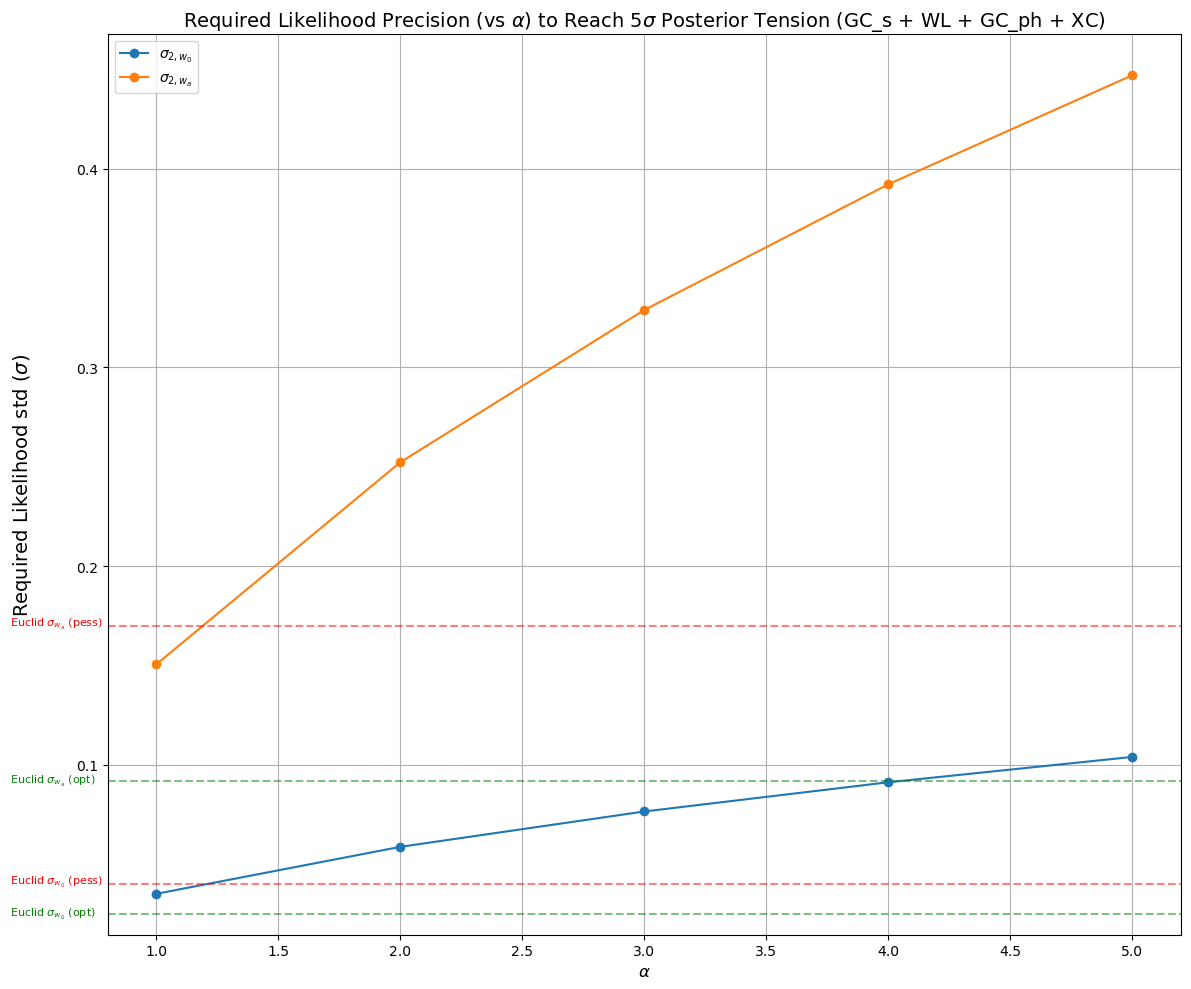

In [857]:
#alpha values: offset from the prior mean in units of prior sigma
alphas = np.array([1, 2, 3, 4, 5])

#converting the list of required sigmas to a numpy array for easier manipulation 
sigma2s_arr = np.array(sigma2s)

#required likelihood standard deviations to achieve a 5 sigma posterior tension
sigma2_w0 = sigma2s_arr[:, 0]
sigma2_wa = sigma2s_arr[:, 1]

#alpha values for plotting
alphas = np.arange(1, len(sigma2s) + 1)

#plot
plt.figure(figsize=(12, 10))
plt.plot(alphas, sigma2_w0, 'o-', label=r'$\sigma_{2,w_0}$')
plt.plot(alphas, sigma2_wa, 'o-', label=r'$\sigma_{2,w_a}$')

#projections for DESI 2024 using pessimistic and optimistic estimates
#probe combo = most powerful = GC(s) + WL + GC(ph) + XC
#pessimistic euclid projections
w0_pess = 0.040
wa_pess = 0.17
plt.axhline(y=w0_pess, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=wa_pess,  color='red', linestyle='--', alpha=0.5)

plt.text(0.4, w0_pess, r'Euclid $\sigma_{w_0}$ (pess)', color='r', fontsize=8)
plt.text(0.4, wa_pess, r'Euclid $\sigma_{w_a}$ (pess)', color='r', fontsize=8) 

#optimistic euclid projections
w0_opt = 0.025
wa_opt = 0.092 
plt.axhline(w0_opt, color='green', linestyle='--', alpha=0.5)
plt.axhline(wa_opt,  color='green', linestyle='--', alpha=0.5) 

plt.text(0.4, w0_opt, r'Euclid $\sigma_{w_0}$ (opt)', color='g', va='center', fontsize=8)
plt.text(0.4, wa_opt, r'Euclid $\sigma_{w_a}$ (opt)', color='g', va='center', fontsize=8) 

#interpolation functions to find alpha for given sigma2 values 
#interp1d from scipy.interpolate to create linear interpolation functions between data points 
#interpolating alpha as a function of sigma2 for both w0 and wa since we want the alpha values for the pessimistic and optimistic Euclid projections 
#exrapolate = extrapolate outside the range of the data points if sigma is outside the range of the provided sigma2 values 
interp_w0 = interp1d(sigma2_w0, alphas, kind='linear', fill_value='extrapolate')
interp_wa = interp1d(sigma2_wa, alphas, kind='linear', fill_value='extrapolate')

#finding alpha where required sigma2 equals Euclid's forecasted precision 
#plugging each Euclid's pessimistic and optimistic projections into the interpolation functions to find the corresponding alpha values 
alpha_w0_pess = float(interp_w0(w0_pess))
alpha_wa_pess = float(interp_wa(wa_pess))
alpha_w0_opt = float(interp_w0(w0_opt))
alpha_wa_opt = float(interp_wa(wa_opt))
print(f"alpha for w0 (pessimistic): {alpha_w0_pess:.3f}")
print(f"alpha for wa (pessimistic): {alpha_wa_pess:.3f}")
print(f"alpha for w0 (optimistic): {alpha_w0_opt:.3f}")
print(f"alpha for wa (optimistic): {alpha_wa_opt:.3f}")

plt.xlabel(fr'$\alpha$', fontsize=12)
plt.ylabel('Required Likelihood std ($\sigma$)', fontsize=14, labelpad=30, loc='center')
plt.title(fr'Required Likelihood Precision (vs $\alpha$) to Reach 5$\sigma$ Posterior Tension (GC_s + WL + GC_ph + XC)', fontsize=14) 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

obtaining 2D prior, likelihood and posterior gaussians, and the corresponding probability desnities of all three distributions

In [858]:
#defining prior mean and covariance - already defined above - changing the variable names for clarity
mu_prior = mu  
cov_prior = cov_matrix

#defining the offset (alpha) in std units from prior - can be adjusted to see how it affects the posterior
alpha = 3
#obtaining the prior standard deviation vector from the covariance matrix 
sigma_prior_vec = np.sqrt(np.diag(cov_prior))
#the likelihood mean is the prior mean plus an offset in units of the prior standard deviation
#shifts the mean by alpha std in each direction - models future measurement that is offset from the prior
mu_like = mu_prior + alpha * sigma_prior_vec

#obtaining the likelihood covariance 
#extract the required sigma2s for the chosen alpha from the list of required sigmas 
sigma_opt = sigma2s[alphas1.index(alpha)]
#creating the covariance matrix for the likelihood, assuming the same correlation as the prior 
cov_like = np.array([
    [sigma_opt[0]**2, row * sigma_opt[0] * sigma_opt[1]],
    [row * sigma_opt[0] * sigma_opt[1], sigma_opt[1]**2]])

#obtaining the posterior mean and covariance using the bayesian update rules 
mu_post, cov_post = find_posterior(mu_prior, cov_prior, mu_like, cov_like)

#setting up meshgrid to plot the 2D Gaussian distributions
#keeping the range wide enough to capture the distributions 
x = np.linspace(mu_prior[0] - 9*sigma_prior_vec[0], mu_prior[0] + 9*sigma_prior_vec[0], 500)
y = np.linspace(mu_prior[1] - 9*sigma_prior_vec[1], mu_prior[1] + 9*sigma_prior_vec[1], 500)
#creates two 2D arrays X and Y that represent all combinations of w0 and wa values 
X, Y = np.meshgrid(x, y)
#stacking X and Y into a 3D array pos where each point is (w0, wa) - a coordinate pair 
pos = np.dstack((X, Y))

#finding the z values for the distributions
#multivariate_normal.pdf computes the probability density function for a multivariate normal distribution 
#z values represent the height of the Gaussian distribution at each point in the grid 
Z_prior = multivariate_normal(mean=mu_prior, cov=cov_prior).pdf(pos)
Z_like = multivariate_normal(mean=mu_like, cov=cov_like).pdf(pos)
Z_post = multivariate_normal(mean=mu_post, cov=cov_post).pdf(pos)


plotting the three gaussians for visualisation. each contour = regions of equal probability density

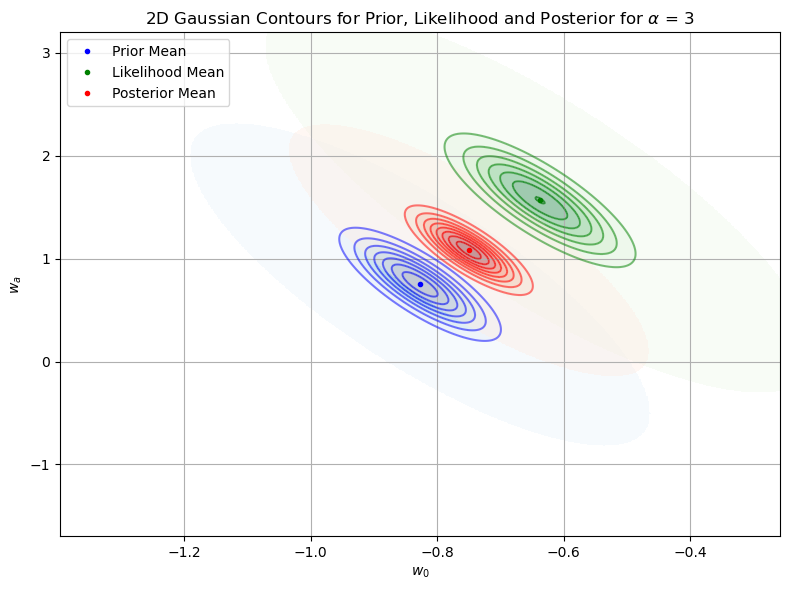

In [859]:
#plotting all three distributions on the same contour plot 
plt.figure(figsize=(8, 6))
#setting values below a threshold to NaN to avoid cluttering the plot with very low probability regions 
Z_prior[Z_prior < 1e-6] = np.nan
cp1 = plt.contourf(X, Y, Z_prior, levels=8, cmap='Blues', alpha=0.4)
Z_like[Z_like < 1e-6] = np.nan
cp2 = plt.contourf(X, Y, Z_like, levels=8, cmap='Greens', alpha=0.4)
Z_post[Z_post < 1e-6] = np.nan
cp3 = plt.contourf(X, Y, Z_post, levels=8, cmap='Reds', alpha=0.4)

cp11 = plt.contour(X, Y, Z_prior, levels=8, colors='blue', alpha=0.5)
cp21 = plt.contour(X, Y, Z_like, levels=8, colors='green', alpha=0.5)
cp31 = plt.contour(X, Y, Z_post, levels=8, colors='red', alpha=0.5)

#plot means for visualisation - prior mean, likelihood mean, and posterior mean
#asterisks are used to unpack the 2D coordinates into separate x and y values for plotting (w0, wa) 
plt.plot(*mu_prior, 'bo', label='Prior Mean', markersize=3)
plt.plot(*mu_like, 'go', label='Likelihood Mean', markersize=3)
plt.plot(*mu_post, 'ro', label='Posterior Mean', markersize=3)

#adding labels and a legend
plt.xlabel(fr'$w_0$')
plt.ylabel(fr'$w_a$')
plt.title(fr'2D Gaussian Contours for Prior, Likelihood and Posterior for $\alpha$ = {alpha}') 
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

converting confidence levels into PDF contour tresholds. drawing 1-5 sigma ellipses for the prior, likelihood and posterior distributions. region enclosed by confidence level = constant mahalanobis distance, PDF of multivariate normal = falls off exponentially, contour level corresponding to confidence levels used to plot the regions

In [860]:
#need to convert the confidence intervals into probability density thresholds for the contours
#defining the confidence levels for 1 to 5 sigma contours - cumulative probabilities that enclose the regions 
confidence_levels = [0.683, 0.954, 0.997, 0.99994, 0.9999994]
#calculating the chi-squared values for these confidence levels - value at which the probability is reached (2D)
#distances correspond to mahalanobis distance squared for the ellipse contours 
chi2_vals = chi2.ppf(confidence_levels, df=2)

#find the peaks of the distributions for prior, likelihood, and posterior - PDF of a multivariate gaussian peaks at its mean
f_peak_prior = multivariate_normal(mean=mu_prior, cov=cov_prior).pdf(mu_prior)
f_peak_like = multivariate_normal(mean=mu_like, cov=cov_like).pdf(mu_like)
f_peak_post = multivariate_normal(mean=mu_post, cov=cov_post).pdf(mu_post)

#convert chi2 thresholds to PDF levels
#the PDF value at the peak is multiplied by the exponential decay factor for each chi-squared value 
#since the PDF falls off exponentially from the peak, this gives the height of the contour lines at each confidence level
levels_prior = sorted(f_peak_prior * np.exp(-0.5 * chi2_vals))
levels_like = sorted(f_peak_like * np.exp(-0.5 * chi2_vals))
levels_post = sorted(f_peak_post * np.exp(-0.5 * chi2_vals))


overlapping of prior/posterior = how tension chnages when likelihood shifts far from prior, tightness of ellipse = uncertainty, visualising the tension 

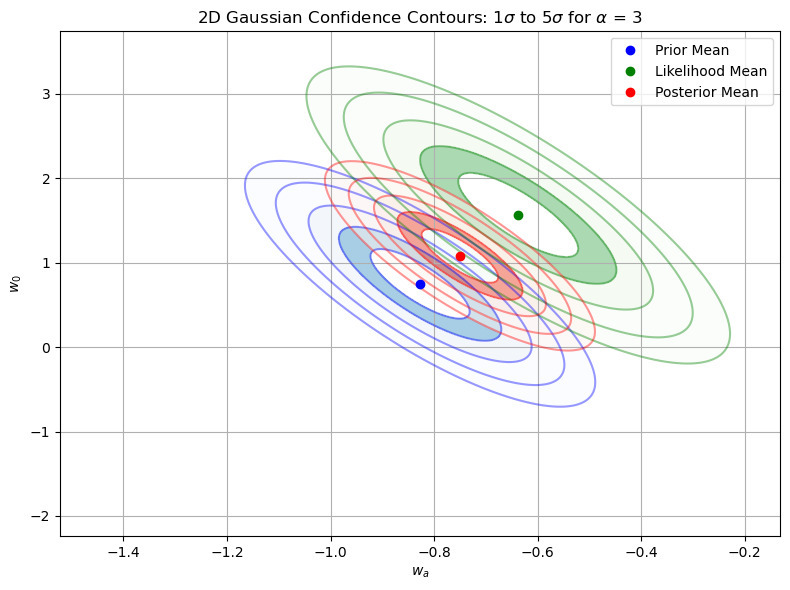

In [861]:
plt.figure(figsize=(8, 6))

#generating another meshgrid for the contours 
#x = w0 range, y = wa range 
x = np.linspace(mu[0] - 11*sigma_prior_vec[0], mu[0] + 11*sigma_prior_vec[0], 500)  
y = np.linspace(mu[1] - 11*sigma_prior_vec[1], mu[1] + 11*sigma_prior_vec[1], 500)  
X, Y = np.meshgrid(x, y)
pos = np.dstack((X,Y))  

#computing the probability density value at each grid point for each of the three gaussians
Z_prior = multivariate_normal(mean=mu_prior, cov=cov_prior).pdf(pos)
Z_like  = multivariate_normal(mean=mu_like,  cov=cov_like).pdf(pos)
Z_post  = multivariate_normal(mean=mu_post,  cov=cov_post).pdf(pos)

#plotting 1 to 5 sigma contours using proper levels
plt.contour(X, Y, Z_prior, levels=levels_prior, colors='blue', alpha=0.4)
plt.contour(X, Y, Z_like,  levels=levels_like,  colors='green', alpha=0.4)
plt.contour(X, Y, Z_post,  levels=levels_post,  colors='red', alpha=0.4)
#plotting filled contours for better visualisation 
plt.contourf(X, Y, Z_prior, levels=levels_prior, cmap='Blues', alpha=0.5)
plt.contourf(X, Y, Z_like,  levels=levels_like,  cmap='Greens', alpha=0.5)
plt.contourf(X, Y, Z_post,  levels=levels_post,  cmap='Reds', alpha=0.5)

#plotting the means
plt.plot(mu_prior[0], mu_prior[1], 'bo', label='Prior Mean')
plt.plot(mu_like[0],  mu_like[1],  'go', label='Likelihood Mean')
plt.plot(mu_post[0],  mu_post[1],  'ro', label='Posterior Mean')

#axis labels and a title 
plt.xlabel(fr'$w_a$')
plt.ylabel(fr'$w_0$')
plt.title(fr'2D Gaussian Confidence Contours: $1\sigma$ to $5\sigma$ for $\alpha$ = {alpha}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


finding the bayes ratio between the null and new hypotheses: simulating a set of hypothetical likelihoods (based on how shifted the means are), finding the bayesian evidence assuming the data is consistent/inconsistent with the prior and then using them for the ratio (quantifies how surprising the offset would be)

alpha   sigma_2,w0     sigma_2,wa     num            denom          logK           K              
1       0.0349734139   0.1505184339   1.181e+01      2.570e-01      3.828          4.596e+01      
2       0.0586142808   0.2522639871   8.295e+00      1.776e-04      10.752         4.672e+04      
3       0.0764208409   0.3288998142   6.267e+00      7.237e-08      18.277         8.660e+07      
4       0.0911211699   0.3921668840   5.012e+00      2.601e-11      25.984         1.927e+11      
5       0.1038782403   0.4470708502   4.169e+00      8.997e-15      33.770         4.634e+14      


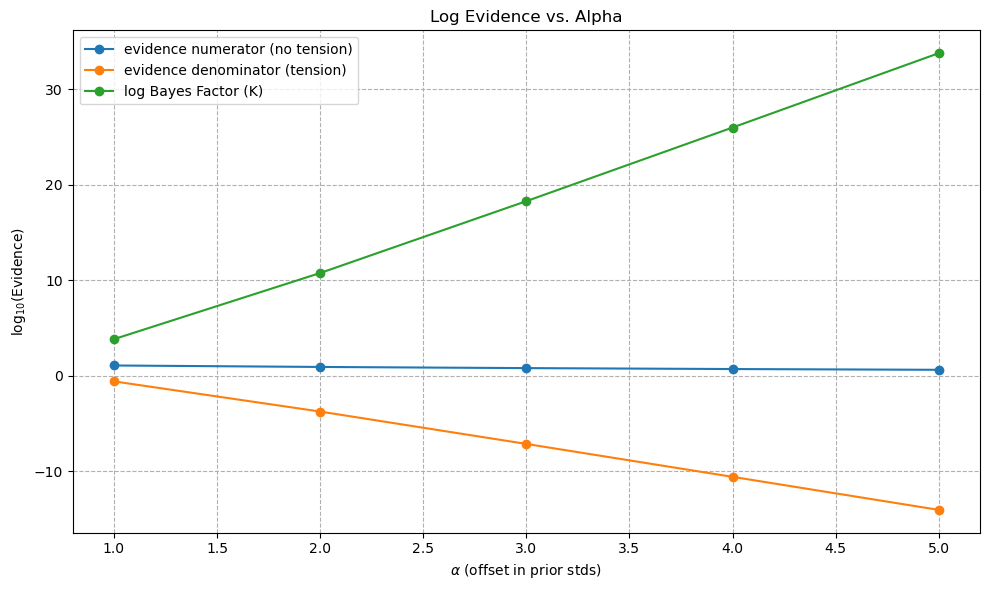

In [862]:
#lists to store results for each alpha 
num_list = []
denom_list = []
logK_list = []
K_list = []
alphas = []
#resetting to avoid duplicating if running the cell multiple times
sigma2s = [] 

print(f"{'alpha':<8}{'sigma_2,w0':<15}{'sigma_2,wa':<15}{'num':<15}{'denom':<15}{'logK':<15}{'K':<15}")

#alphas1 = [1, 2, 3, 4, 5] - different mean offsets in units of prior std 
for alpha in alphas1:
    #calling the function to find the required likelihood covariance for the given alpha and target tension 
    required_sigmas = likelihood_cov_for_tension(mu, cov_matrix, alpha, row, target_t)
    #if optimisation was successful, calculating the evidence for "no tension" and "tension" 
    if required_sigmas is not None:
        #saving the returned sigma2 values for w0 and wa (future likelihood stds) 
        sigma2_w0, sigma2_wa = required_sigmas
        sigma2s.append(required_sigmas)
        alphas.append(alpha)
        
        #likelihood mean/covariance matrix for the future measurement 
        mu_like = mu + alpha * np.array([w0_sigma, wa_sigma])
        cov_like = np.array([
            [sigma2_w0**2, row * sigma2_w0 * sigma2_wa],
            [row * sigma2_w0 * sigma2_wa, sigma2_wa**2]
        ])
        #adding the likelihood covariance to the prior covariance to get the total covariance (needed for gaussian overlap formula)
        cov_sum = cov_matrix + cov_like

        #calculating the numerator = evidence for "no tension"
        #the normalisation factor for the multivariate Gaussian since the exponential becomes 1 due to mean being at the prior mean 
        num = (1 / (2 * np.pi * np.sqrt(np.linalg.det(cov_sum))))
        #calculating the denominator: evidence for "tension"
        #the mean is shifted by alpha std from the prior mean 
        diff_offset = mu_like - mu
        #the exponential term is the squared mahalanobis distance between the shifted mean and the prior mean, scaled by the covariance 
        denom = num * np.exp(-0.5 * diff_offset @ np.linalg.inv(cov_sum) @ diff_offset)
        #storing the results in lists for later use 
        num_list.append(num)
        denom_list.append(denom)

        #calculating the bayes factor - the ratio of the two evidences 
        K = num / denom
        #in log form since it is more convenient for plotting and interpretation
        logK = np.log(K)
        logK_list.append(logK)
        K_list.append(K)

        print(f"{alpha:<8}{sigma2_w0:<15.10f}{sigma2_wa:<15.10f}{num:<15.3e}{denom:<15.3e}{logK:<15.3f}{K:<15.3e}")
    else:
        print(f"{alpha:<8}optimization failed")

#convert lists to arrays for plotting
alphas = np.array(alphas)
num_list = np.array(num_list)
denom_list = np.array(denom_list)
K_list = np.array(K_list)

#showing the results in a plot 
#expect the numerator to be constant (evidence for "no tension" is the same for all alphas) 
#denominator should decrease as alpha increases (data looks less consistent with the prior as we move further away from it) 
#bayes factor K should increase as alpha increases (more evidence for tension as we move further from the prior mean)  
plt.figure(figsize=(10, 6))
plt.plot(alphas, np.log10(num_list), marker='o', label='evidence numerator (no tension)')
plt.plot(alphas, np.log10(denom_list), marker='o', label='evidence denominator (tension)') 
plt.plot(alphas, logK_list , marker='o', label='log Bayes Factor (K)')  
plt.xlabel(r'$\alpha$ (offset in prior stds)')
plt.ylabel(r'$\log_{10}$(Evidence)')
plt.title('Log Evidence vs. Alpha')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


given a future experiment precision, how large does the shift in the data need to be before the evidence for tension becomes meaningful? 

pessimistic tension detection thresholds:
  alpha for log₁₀K ≥ 0.5: 0.5728643216
  alpha for log₁₀K ≥ 1.0: 0.8040201005
  alpha for log₁₀K ≥ 2.0: 1.1356783920
optimistic tension detection thresholds:
  alpha for log₁₀K ≥ 0.5: 0.5125628141
  alpha for log₁₀K ≥ 1.0: 0.7336683417
  alpha for log₁₀K ≥ 2.0: 1.0251256281


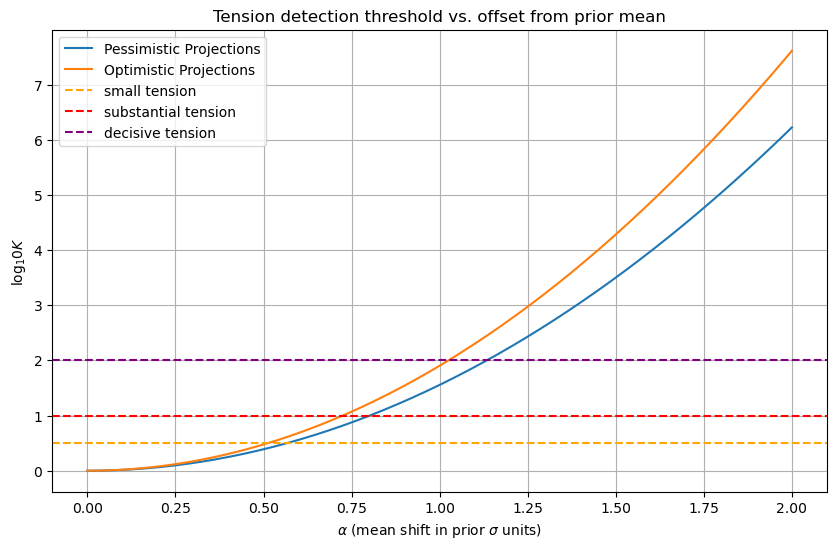

In [887]:
#from: Euclid Collaboration et al.: Euclid preparation: VII. Forecast validation for Euclid cosmological probes
#pessimistic projections for w0 and wa 
sigma2_w0 = 0.040  
sigma2_wa = 0.17    
row = -0.8 

#optimistic projections for w0 and wa  
sigma2_w0o = 0.025 
sigma2_wao = 0.092
  
#likelihood covariance matrix for the Euclid projections
cov_like = np.array([
    [sigma2_w0**2, row * sigma2_w0 * sigma2_wa],
    [row * sigma2_w0 * sigma2_wa, sigma2_wa**2]]) 

cov_likeo = np.array([
    [sigma2_w0o**2, row * sigma2_w0o * sigma2_wao],
    [row * sigma2_w0o * sigma2_wao, sigma2_wao**2]]) 

#choosing an alpha range to test the Euclid projections 
alphas = np.linspace(0, 2, 200)  # alpha = offset in prior sigmas

logK_list = []
logK_listo = []

for alpha in alphas:
    mu_like = mu + alpha * np.array([w0_sigma, wa_sigma])
    delta = mu_like - mu
    cov_sum = cov_matrix + cov_like
    mahal = delta.T @ np.linalg.inv(cov_sum) @ delta
    logK = 0.5 * mahal
    log10K = logK / np.log(10)
    logK_list.append(log10K)

for alpha in alphas:
    mu_like = mu + alpha * np.array([w0_sigma, wa_sigma])
    delta = mu_like - mu
    cov_sum = cov_matrix + cov_likeo
    mahal = delta.T @ np.linalg.inv(cov_sum) @ delta
    logK = 0.5 * mahal
    log10Ko = logK / np.log(10)
    logK_listo.append(log10Ko)

#using jeffreys rating scale for interpreting the tension 
plt.figure(figsize=(10, 6))
plt.plot(alphas, logK_list, label='Pessimistic Projections') 
plt.plot(alphas, logK_listo, label='Optimistic Projections') 
plt.axhline(0.5, color='orange', linestyle='--', label='small tension')
plt.axhline(1.0, color='red', linestyle='--', label='substantial tension')
plt.axhline(2.0, color='purple', linestyle='--', label='decisive tension')
plt.xlabel(fr'$\alpha$ (mean shift in prior $\sigma$ units)')
plt.ylabel(fr'$\log_{10} K$')
plt.title('Tension detection threshold vs. offset from prior mean')
plt.legend()
plt.grid(True)


thresholds = [0.5, 1.0, 2.0]
logK_array = np.array(logK_list)
logK_arrayo = np.array(logK_listo)

print(f"pessimistic tension detection thresholds:")
for thresh in thresholds:
    idx = np.argmax(logK_array >= thresh)
    print(f"  alpha for log₁₀K ≥ {thresh}: {alphas[idx]:.10f}")

print(f"optimistic tension detection thresholds:")
for thresh in thresholds:
    idx = np.argmax(logK_arrayo >= thresh)
    print(f"  alpha for log₁₀K ≥ {thresh}: {alphas[idx]:.10f}")



what values of the likelihood covariance (sigma2 for w0 and wa) are needed to achieve a desired bayes factor (K) for a given alpha? given prior mean and covariance and shifted likelihood mean and target bayes factor, solving for values of sigma2 for w0 and wa that give logK = target, using minimisation of the squared error

alpha   σ₂_w₀          σ₂_wₐ          
0.000   0.000000       0.000000       
0.116   0.000000       0.000000       
0.232   0.000000       0.000000       
0.347   0.011119       0.000000       
0.463   0.036581       0.000000       
0.579   0.000000       0.231757       
0.695   0.069342       0.000000       
0.811   0.084047       0.000000       
0.926   0.098319       0.000000       
1.042   0.112322       0.000000       
1.158   0.000000       0.542906       
1.274   0.000000       0.601862       
1.389   0.000000       0.660421       
1.505   0.000000       0.718680       
1.621   0.000000       0.776707       
1.737   0.000000       0.834550       
1.853   0.254070       1.093468       
1.968   0.270902       1.165907       
2.084   0.287679       1.238113       
2.200   0.304412       1.310126       


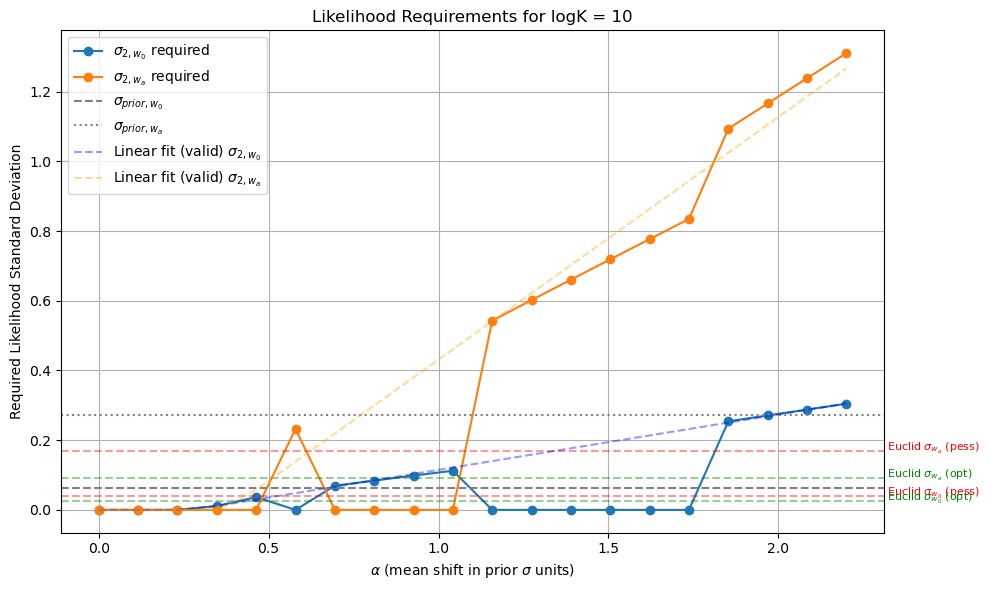

In [ ]:
#desired log bayes factor
target_logK = 10
#range of alphas to test 
alphas = np.linspace(0, 2.2, 20)
#prior standard deviations for w0 and wa 
sigma_prior_vec = np.sqrt(np.diag(cov_matrix)) 

#finding the log bayes factor between the prior and likelihood for a given alpha 
def compute_logK(mu, cov_prior, mu_like, cov_like):
    #computing posterior covariance and mean using bayesian update rules 
    #cov_post = (cov_prior^-1 + cov_like^-1)^-1
    #mu_post = cov_post @ (cov_prior^-1 @ mu + cov_like^-1 @ mu_like) 
    cov_post = np.linalg.inv(np.linalg.inv(cov_prior) + np.linalg.inv(cov_like))
    mu_post = cov_post @ (np.linalg.inv(cov_prior) @ mu + np.linalg.inv(cov_like) @ mu_like)

    #finding the differences between the means - to be used in the logK calculation 
    #diff_null = mu - mu_post (difference between prior mean and posterior mean)
    #diff_shifted = mu_like - mu_post (difference between likelihood mean and posterior mean) 
    diff_null = mu - mu_post    
    diff_shifted = mu_like - mu_post

    #calculating the log determinants of the covariance matrices 
    #gives the volume of the gaussian ellipses - smaller determinant = more concentrated distribution (tighter ellipse) 
    #bayes factor K is sensitive to the relative volumes of the prior, likelihood, and posterior distributions 
    log_det_prior = np.linalg.slogdet(cov_prior)[1]
    log_det_like = np.linalg.slogdet(cov_like)[1]
    log_det_post = np.linalg.slogdet(cov_post)[1]

    #fidning the log bayes factor K using the formula: 
    #logk = 1/2 * (log_det_post - log_det_prior - log_det_like) - 0.5 * (diff_null @ inv(cov_prior) @ diff_null + diff_shifted @ inv(cov_like) @ diff_shifted) 
    #first term is the log volume ratio of the posterior to prior and likelihood - if posterior is smaller = agreement between prior and likelihood 
    #second term is the mahalanobis distance between the prior and posterior means, scaled by the prior covariance
    #if posterior mean is closer to prior mean = less tension = smaller logK 
    logK = 0.5 * (log_det_post - log_det_prior - log_det_like) \
           - 0.5 * (diff_null @ np.linalg.inv(cov_prior) @ diff_null
                    + diff_shifted @ np.linalg.inv(cov_like) @ diff_shifted)
    return logK

#numerically solving for the required likelihood standard deviations that give the desired logK, when the likelihood mean is shifted by alpha std from the prior mean 
def find_sigmas_for_logK(alpha, target_logK, row=-0.8):
    #mean of the likelihood is the prior mean plus an offset in units of the prior standard deviation 
    mu_like = mu + alpha * sigma_prior_vec

    #takes in a trial pair of likelihood standard deviations (sigma2_w0, sigma2_wa) 
    def objective(sigma2s):
        #sigma2s is a 2-element array of likelihood variances (w0, wa)
        #ensuring the variances are positive, otherwise return a large penalty value
        sigma2_w0, sigma2_wa = sigma2s
        if sigma2_w0 <= 0 or sigma2_wa <= 0:
            #ensuring that the optimization does not explore negative variances 
            return 1e6 
        #constructing the covariance matrix for the likelihood with the given variances and correlation 
        cov_like = np.array([
            [sigma2_w0**2, row * sigma2_w0 * sigma2_wa],
            [row * sigma2_w0 * sigma2_wa, sigma2_wa**2]])
        #computing the logK for the given likelihood covariance and prior covariance 
        logK = compute_logK(mu, cov_prior, mu_like, cov_like)
        #returning a squared difference between computed logK and target logK 
        #this is the objective function to minimize - the closer logK is to target_logK, the smaller the value returned
        #the optimizer will try to find the sigma2_w0 and sigma2_wa that minimize this difference 
        return (logK - target_logK)**2
    #stting up optimiser that will be used - for bounded problems
    minimizer_kwargs = {
        "method": "L-BFGS-B",
        #must be greater than 1e-8
        "bounds": [(1e-8, None), (1e-8, None)],
        #small gradient tolerence = high precision 
        "options": {"gtol": 1e-8}}
    #global optimisation algorithm - runs local optimiser multiple times 
    result = basinhopping(
        objective,
        x0=sigma_prior_vec,
        minimizer_kwargs=minimizer_kwargs,
        niter=150,
        stepsize=0.001,
        disp=False)
    #checking that optimisation succeeded 
    if result.lowest_optimization_result.success:
        s0, s1 = result.x
        return max(s0, 1e-8), max(s1, 1e-8)
    else:
        return np.nan, np.nan

sigma2_w0_list = []
sigma2_wa_list = []

#iterating over all alphas to find required sigma 2 values and appending the lists 
print(f"{'alpha':<8}{'σ₂_w₀':<15}{'σ₂_wₐ':<15}")
for alpha in alphas:
    s0, s1 = find_sigmas_for_logK(alpha, target_logK)
    sigma2_w0_list.append(s0)
    sigma2_wa_list.append(s1)
    print(f"{alpha:<8.3f}{s0:<15.6f}{s1:<15.6f}")

#plotting the required likelihood standard deviations vs alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, sigma2_w0_list, 'o-', label=r'$\sigma_{2,w_0}$ required')
plt.plot(alphas, sigma2_wa_list, 'o-', label=r'$\sigma_{2,w_a}$ required')

#plotting the original prior standard deviations as reference lines
plt.axhline(y=w0_sigma, color='gray', linestyle='--', label=r'$\sigma_{prior,w_0}$')
plt.axhline(y=wa_sigma, color='gray', linestyle=':', label=r'$\sigma_{prior,w_a}$')

#projections for DESI 2024 using pessimistic and optimistic estimates
#probe combo = most powerful = GC(s) + WL + GC(ph) + XC
#pessimistic euclid projections
w0_pess = 0.040
wa_pess = 0.17
plt.axhline(y=w0_pess, color='red', linestyle='--', alpha=0.4)
plt.axhline(y=wa_pess,  color='red', linestyle='--', alpha=0.4)

plt.text(2.32, w0_pess, r'Euclid $\sigma_{w_0}$ (pess)', color='r', fontsize=8)
plt.text(2.32, wa_pess, r'Euclid $\sigma_{w_a}$ (pess)', color='r', fontsize=8) 

#optimistic euclid projections
w0_opt = 0.025
wa_opt = 0.092 
plt.axhline(w0_opt, color='green', linestyle='--', alpha=0.4)
plt.axhline(wa_opt,  color='green', linestyle='--', alpha=0.4) 

plt.text(2.32, w0_opt, r'Euclid $\sigma_{w_0}$ (opt)', color='g', fontsize=8)
plt.text(2.32, wa_opt, r'Euclid $\sigma_{w_a}$ (opt)', color='g', fontsize=8) 

from numpy.polynomial.polynomial import polyfit

# Convert to arrays
alphas_arr = np.array(alphas)
w0_arr = np.array(sigma2_w0_list)
wa_arr = np.array(sigma2_wa_list)

# Define a threshold: exclude points where σ₂ is near-zero (e.g., < 0.01)
threshold = 0.001
valid_w0 = (w0_arr > threshold) & (~np.isnan(w0_arr))
valid_wa = (wa_arr > threshold) & (~np.isnan(wa_arr))

# Linear fit only to the valid subset
b_w0, m_w0 = polyfit(alphas_arr[valid_w0], w0_arr[valid_w0], deg=1)
b_wa, m_wa = polyfit(alphas_arr[valid_wa], wa_arr[valid_wa], deg=1)

# Evaluate over all alpha for smooth plotting
line_fit_w0 = m_w0 * alphas_arr + b_w0
line_fit_wa = m_wa * alphas_arr + b_wa

plt.plot(alphas, np.clip(line_fit_w0, 0, None), '--', color='blue', alpha=0.4, label=r'Linear fit $\sigma_{2,w_0}$')
plt.plot(alphas, np.clip(line_fit_wa, 0, None), '--', color='orange', alpha=0.4, label=r'Linear fit $\sigma_{2,w_a}$')

plt.xlabel(fr'$\alpha$ (mean shift in prior $\sigma$ units)')
plt.ylabel('Required Likelihood Standard Deviation')
plt.title(f'Likelihood Requirements for logK = {target_logK}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

